<a href="https://colab.research.google.com/github/arshmehar/ssh_Indian_Ocean/blob/main/patchtst_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import xarray as xr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, Callback

In [ ]:
ds = xr.open_dataset("/content/drive/MyDrive/prerna_data/hadgem_aviso.nc", decode_times=False, engine="h5netcdf")
ds = ds.mean(dim="ensemble_member")

X_in = ds.DSL.fillna(0).values
y_in = ds.avisodsl.fillna(0).values


In [ ]:
T, H, W = X_in.shape
print(f"Full cube : T={T}, H={H}, W={W}")#t is time steps, lat, long

Full cube : T=264, H=240, W=360


In [ ]:
X_in = X_in.reshape(T, -1)
y_in = y_in.reshape(T, -1)

In [ ]:
X_grid = X_in.T     # shape: (H*W, T)
y_grid = y_in.T     # shape: (H*W, T)

In [ ]:
n_pixels=X_grid.shape[0]
pix_ids      = np.arange(n_pixels)                 # 0 … 86 399
rng          = np.random.default_rng(42)        # reproducible
rng.shuffle(pix_ids) # permutes the list in‑place; every pixel gets a new random position.

In [ ]:
n_train      = int(0.80 * n_pixels)
n_val        = int(0.10 * n_pixels)

train_ids    = pix_ids[:n_train]
val_ids      = pix_ids[n_train:n_train+n_val]
test_ids     = pix_ids[n_train+n_val:]

In [ ]:
X_train = X_grid[train_ids]   # shape: (n_train, T)
y_train = y_grid[train_ids]

X_val = X_grid[val_ids]
y_val = y_grid[val_ids]

X_test = X_grid[test_ids]
y_test = y_grid[test_ids]

In [ ]:
print("Pixel‑only cubes  :")
for name, arr in [("train", X_train), ("val", X_val), ("test", X_test)]:
    print(f"{name:5s}  {arr.shape}")


Pixel‑only cubes  :
train  (69120, 264)
val    (8640, 264)
test   (8640, 264)


# PatchTST

In [ ]:
__all__ = ['Transpose', 'get_activation_fn', 'moving_avg', 'series_decomp', 'PositionalEncoding', 'SinCosPosEncoding', 'Coord2dPosEncoding', 'Coord1dPosEncoding', 'positional_encoding']

import torch
from torch import nn
import math

class Transpose(nn.Module):
    def __init__(self, *dims, contiguous=False):
        super().__init__()
        self.dims, self.contiguous = dims, contiguous
    def forward(self, x):
        if self.contiguous: return x.transpose(*self.dims).contiguous()
        else: return x.transpose(*self.dims)


def get_activation_fn(activation):
    if callable(activation): return activation()
    elif activation.lower() == "relu": return nn.ReLU()
    elif activation.lower() == "gelu": return nn.GELU()
    raise ValueError(f'{activation} is not available. You can use "relu", "gelu", or a callable')


# decomposition

class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean



# pos_encoding

def PositionalEncoding(q_len, d_model, normalize=True):
    pe = torch.zeros(q_len, d_model)
    position = torch.arange(0, q_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    if normalize:
        pe = pe - pe.mean()
        pe = pe / (pe.std() * 10)
    return pe

SinCosPosEncoding = PositionalEncoding

def Coord2dPosEncoding(q_len, d_model, exponential=False, normalize=True, eps=1e-3, verbose=False):
    x = .5 if exponential else 1
    i = 0
    for i in range(100):
        cpe = 2 * (torch.linspace(0, 1, q_len).reshape(-1, 1) ** x) * (torch.linspace(0, 1, d_model).reshape(1, -1) ** x) - 1
        pv(f'{i:4.0f}  {x:5.3f}  {cpe.mean():+6.3f}', verbose)
        if abs(cpe.mean()) <= eps: break
        elif cpe.mean() > eps: x += .001
        else: x -= .001
        i += 1
    if normalize:
        cpe = cpe - cpe.mean()
        cpe = cpe / (cpe.std() * 10)
    return cpe

def Coord1dPosEncoding(q_len, exponential=False, normalize=True):
    cpe = (2 * (torch.linspace(0, 1, q_len).reshape(-1, 1)**(.5 if exponential else 1)) - 1)
    if normalize:
        cpe = cpe - cpe.mean()
        cpe = cpe / (cpe.std() * 10)
    return cpe

def positional_encoding(pe, learn_pe, q_len, d_model):
    # Positional encoding
    if pe == None:
        W_pos = torch.empty((q_len, d_model)) # pe = None and learn_pe = False can be used to measure impact of pe
        nn.init.uniform_(W_pos, -0.02, 0.02)
        learn_pe = False
    elif pe == 'zero':
        W_pos = torch.empty((q_len, 1))
        nn.init.uniform_(W_pos, -0.02, 0.02)
    elif pe == 'zeros':
        W_pos = torch.empty((q_len, d_model))
        nn.init.uniform_(W_pos, -0.02, 0.02)
    elif pe == 'normal' or pe == 'gauss':
        W_pos = torch.zeros((q_len, 1))
        torch.nn.init.normal_(W_pos, mean=0.0, std=0.1)
    elif pe == 'uniform':
        W_pos = torch.zeros((q_len, 1))
        nn.init.uniform_(W_pos, a=0.0, b=0.1)
    elif pe == 'lin1d': W_pos = Coord1dPosEncoding(q_len, exponential=False, normalize=True)
    elif pe == 'exp1d': W_pos = Coord1dPosEncoding(q_len, exponential=True, normalize=True)
    elif pe == 'lin2d': W_pos = Coord2dPosEncoding(q_len, d_model, exponential=False, normalize=True)
    elif pe == 'exp2d': W_pos = Coord2dPosEncoding(q_len, d_model, exponential=True, normalize=True)
    elif pe == 'sincos': W_pos = PositionalEncoding(q_len, d_model, normalize=True)
    else: raise ValueError(f"{pe} is not a valid pe (positional encoder. Available types: 'gauss'=='normal', \
        'zeros', 'zero', uniform', 'lin1d', 'exp1d', 'lin2d', 'exp2d', 'sincos', None.)")
    return nn.Parameter(W_pos, requires_grad=learn_pe)

In [ ]:
# code from https://github.com/ts-kim/RevIN, with minor modifications

import torch
import torch.nn as nn

class RevIN(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=True, subtract_last=False):
        """
        :param num_features: the number of features or channels
        :param eps: a value added for numerical stability
        :param affine: if True, RevIN has learnable affine parameters
        """
        super(RevIN, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        self.subtract_last = subtract_last
        if self.affine:
            self._init_params()

    def forward(self, x, mode:str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else: raise NotImplementedError
        return x

    def _init_params(self):
        # initialize RevIN params: (C,)
        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim-1))
        if self.subtract_last:
            self.last = x[:,-1,:].unsqueeze(1)
        else:
            self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        if self.subtract_last:
            x = x - self.last
        else:
            x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps*self.eps)
        x = x * self.stdev
        if self.subtract_last:
            x = x + self.last
        else:
            x = x + self.mean
        return x

In [ ]:
__all__ = ['PatchTST_backbone']

# Cell
from typing import Callable, Optional
import torch
from torch import nn
from torch import Tensor
import torch.nn.functional as F
import numpy as np

#from collections import OrderedDict
# from layers.PatchTST_layers import *
# from layers.RevIN import RevIN

# Cell
class PatchTST_backbone(nn.Module):
    def __init__(self, c_in:int, context_window:int, target_window:int, patch_len:int, stride:int, max_seq_len:Optional[int]=1024,
                 n_layers:int=3, d_model=128, n_heads=16, d_k:Optional[int]=None, d_v:Optional[int]=None,
                 d_ff:int=256, norm:str='BatchNorm', attn_dropout:float=0., dropout:float=0., act:str="gelu", key_padding_mask:bool='auto',
                 padding_var:Optional[int]=None, attn_mask:Optional[Tensor]=None, res_attention:bool=True, pre_norm:bool=False, store_attn:bool=False,
                 pe:str='zeros', learn_pe:bool=True, fc_dropout:float=0., head_dropout = 0, padding_patch = None,
                 pretrain_head:bool=False, head_type = 'flatten', individual = False, revin = True, affine = True, subtract_last = False,
                 verbose:bool=False, **kwargs):

        super().__init__()

        # RevIn
        self.revin = revin
        if self.revin: self.revin_layer = RevIN(c_in, affine=affine, subtract_last=subtract_last)

        # Patching
        self.patch_len = patch_len
        self.stride = stride
        self.padding_patch = padding_patch
        patch_num = int((context_window - patch_len)/stride + 1)
        if padding_patch == 'end': # can be modified to general case
            self.padding_patch_layer = nn.ReplicationPad1d((0, stride))
            patch_num += 1

        # Backbone
        self.backbone = TSTiEncoder(c_in, patch_num=patch_num, patch_len=patch_len, max_seq_len=max_seq_len,
                                n_layers=n_layers, d_model=d_model, n_heads=n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff,
                                attn_dropout=attn_dropout, dropout=dropout, act=act, key_padding_mask=key_padding_mask, padding_var=padding_var,
                                attn_mask=attn_mask, res_attention=res_attention, pre_norm=pre_norm, store_attn=store_attn,
                                pe=pe, learn_pe=learn_pe, verbose=verbose, **kwargs)

        # Head
        self.head_nf = d_model * patch_num
        self.n_vars = c_in
        self.pretrain_head = pretrain_head
        self.head_type = head_type
        self.individual = individual

        if self.pretrain_head:
            self.head = self.create_pretrain_head(self.head_nf, c_in, fc_dropout) # custom head passed as a partial func with all its kwargs
        elif head_type == 'flatten':
            self.head = Flatten_Head(self.individual, self.n_vars, self.head_nf, target_window, head_dropout=head_dropout)


    def forward(self, z):                                                                   # z: [bs x nvars x seq_len]
        # norm
        if self.revin:
            z = z.permute(0,2,1)
            z = self.revin_layer(z, 'norm')
            z = z.permute(0,2,1)

        # do patching
        if self.padding_patch == 'end':
            z = self.padding_patch_layer(z)
        z = z.unfold(dimension=-1, size=self.patch_len, step=self.stride)                   # z: [bs x nvars x patch_num x patch_len]
        z = z.permute(0,1,3,2)                                                              # z: [bs x nvars x patch_len x patch_num]

        # model
        z = self.backbone(z)                                                                # z: [bs x nvars x d_model x patch_num]
        z = self.head(z)                                                                    # z: [bs x nvars x target_window]

        # denorm
        if self.revin:
            z = z.permute(0,2,1)
            z = self.revin_layer(z, 'denorm')
            z = z.permute(0,2,1)
        return z

    def create_pretrain_head(self, head_nf, vars, dropout):
        return nn.Sequential(nn.Dropout(dropout),
                    nn.Conv1d(head_nf, vars, 1)
                    )


class Flatten_Head(nn.Module):
    def __init__(self, individual, n_vars, nf, target_window, head_dropout=0):
        super().__init__()

        self.individual = individual
        self.n_vars = n_vars

        if self.individual:
            self.linears = nn.ModuleList()
            self.dropouts = nn.ModuleList()
            self.flattens = nn.ModuleList()
            for i in range(self.n_vars):
                self.flattens.append(nn.Flatten(start_dim=-2))
                self.linears.append(nn.Linear(nf, target_window))
                self.dropouts.append(nn.Dropout(head_dropout))
        else:
            self.flatten = nn.Flatten(start_dim=-2)
            self.linear = nn.Linear(nf, target_window)
            self.dropout = nn.Dropout(head_dropout)

    def forward(self, x):                                 # x: [bs x nvars x d_model x patch_num]
        if self.individual:
            x_out = []
            for i in range(self.n_vars):
                z = self.flattens[i](x[:,i,:,:])          # z: [bs x d_model * patch_num]
                z = self.linears[i](z)                    # z: [bs x target_window]
                z = self.dropouts[i](z)
                x_out.append(z)
            x = torch.stack(x_out, dim=1)                 # x: [bs x nvars x target_window]
        else:
            x = self.flatten(x)
            x = self.linear(x)
            x = self.dropout(x)
        return x




class TSTiEncoder(nn.Module):  #i means channel-independent
    def __init__(self, c_in, patch_num, patch_len, max_seq_len=1024,
                 n_layers=3, d_model=128, n_heads=16, d_k=None, d_v=None,
                 d_ff=256, norm='BatchNorm', attn_dropout=0., dropout=0., act="gelu", store_attn=False,
                 key_padding_mask='auto', padding_var=None, attn_mask=None, res_attention=True, pre_norm=False,
                 pe='zeros', learn_pe=True, verbose=False, **kwargs):


        super().__init__()

        self.patch_num = patch_num
        self.patch_len = patch_len

        # Input encoding
        q_len = patch_num
        self.W_P = nn.Linear(patch_len, d_model)        # Eq 1: projection of feature vectors onto a d-dim vector space
        self.seq_len = q_len

        # Positional encoding
        self.W_pos = positional_encoding(pe, learn_pe, q_len, d_model)

        # Residual dropout
        self.dropout = nn.Dropout(dropout)

        # Encoder
        self.encoder = TSTEncoder(q_len, d_model, n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff, norm=norm, attn_dropout=attn_dropout, dropout=dropout,
                                   pre_norm=pre_norm, activation=act, res_attention=res_attention, n_layers=n_layers, store_attn=store_attn)


    def forward(self, x) -> Tensor:                                              # x: [bs x nvars x patch_len x patch_num]

        n_vars = x.shape[1]
        # Input encoding
        x = x.permute(0,1,3,2)                                                   # x: [bs x nvars x patch_num x patch_len]
        x = self.W_P(x)                                                          # x: [bs x nvars x patch_num x d_model]

        u = torch.reshape(x, (x.shape[0]*x.shape[1],x.shape[2],x.shape[3]))      # u: [bs * nvars x patch_num x d_model]
        u = self.dropout(u + self.W_pos)                                         # u: [bs * nvars x patch_num x d_model]

        # Encoder
        z = self.encoder(u)                                                      # z: [bs * nvars x patch_num x d_model]
        z = torch.reshape(z, (-1,n_vars,z.shape[-2],z.shape[-1]))                # z: [bs x nvars x patch_num x d_model]
        z = z.permute(0,1,3,2)                                                   # z: [bs x nvars x d_model x patch_num]

        return z



# Cell
class TSTEncoder(nn.Module):
    def __init__(self, q_len, d_model, n_heads, d_k=None, d_v=None, d_ff=None,
                        norm='BatchNorm', attn_dropout=0., dropout=0., activation='gelu',
                        res_attention=False, n_layers=1, pre_norm=False, store_attn=False):
        super().__init__()

        self.layers = nn.ModuleList([TSTEncoderLayer(q_len, d_model, n_heads=n_heads, d_k=d_k, d_v=d_v, d_ff=d_ff, norm=norm,
                                                      attn_dropout=attn_dropout, dropout=dropout,
                                                      activation=activation, res_attention=res_attention,
                                                      pre_norm=pre_norm, store_attn=store_attn) for i in range(n_layers)])
        self.res_attention = res_attention

    def forward(self, src:Tensor, key_padding_mask:Optional[Tensor]=None, attn_mask:Optional[Tensor]=None):
        output = src
        scores = None
        if self.res_attention:
            for mod in self.layers: output, scores = mod(output, prev=scores, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
            return output
        else:
            for mod in self.layers: output = mod(output, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
            return output



class TSTEncoderLayer(nn.Module):
    def __init__(self, q_len, d_model, n_heads, d_k=None, d_v=None, d_ff=256, store_attn=False,
                 norm='BatchNorm', attn_dropout=0, dropout=0., bias=True, activation="gelu", res_attention=False, pre_norm=False):
        super().__init__()
        assert not d_model%n_heads, f"d_model ({d_model}) must be divisible by n_heads ({n_heads})"
        d_k = d_model // n_heads if d_k is None else d_k
        d_v = d_model // n_heads if d_v is None else d_v

        # Multi-Head attention
        self.res_attention = res_attention
        self.self_attn = _MultiheadAttention(d_model, n_heads, d_k, d_v, attn_dropout=attn_dropout, proj_dropout=dropout, res_attention=res_attention)

        # Add & Norm
        self.dropout_attn = nn.Dropout(dropout)
        if "batch" in norm.lower():
            self.norm_attn = nn.Sequential(Transpose(1,2), nn.BatchNorm1d(d_model), Transpose(1,2))
        else:
            self.norm_attn = nn.LayerNorm(d_model)

        # Position-wise Feed-Forward
        self.ff = nn.Sequential(nn.Linear(d_model, d_ff, bias=bias),
                                get_activation_fn(activation),
                                nn.Dropout(dropout),
                                nn.Linear(d_ff, d_model, bias=bias))

        # Add & Norm
        self.dropout_ffn = nn.Dropout(dropout)
        if "batch" in norm.lower():
            self.norm_ffn = nn.Sequential(Transpose(1,2), nn.BatchNorm1d(d_model), Transpose(1,2))
        else:
            self.norm_ffn = nn.LayerNorm(d_model)

        self.pre_norm = pre_norm
        self.store_attn = store_attn


    def forward(self, src:Tensor, prev:Optional[Tensor]=None, key_padding_mask:Optional[Tensor]=None, attn_mask:Optional[Tensor]=None) -> Tensor:

        # Multi-Head attention sublayer
        if self.pre_norm:
            src = self.norm_attn(src)
        ## Multi-Head attention
        if self.res_attention:
            src2, attn, scores = self.self_attn(src, src, src, prev, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        else:
            src2, attn = self.self_attn(src, src, src, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        if self.store_attn:
            self.attn = attn
        ## Add & Norm
        src = src + self.dropout_attn(src2) # Add: residual connection with residual dropout
        if not self.pre_norm:
            src = self.norm_attn(src)

        # Feed-forward sublayer
        if self.pre_norm:
            src = self.norm_ffn(src)
        ## Position-wise Feed-Forward
        src2 = self.ff(src)
        ## Add & Norm
        src = src + self.dropout_ffn(src2) # Add: residual connection with residual dropout
        if not self.pre_norm:
            src = self.norm_ffn(src)

        if self.res_attention:
            return src, scores
        else:
            return src




class _MultiheadAttention(nn.Module):
    def __init__(self, d_model, n_heads, d_k=None, d_v=None, res_attention=False, attn_dropout=0., proj_dropout=0., qkv_bias=True, lsa=False):
        """Multi Head Attention Layer
        Input shape:
            Q:       [batch_size (bs) x max_q_len x d_model]
            K, V:    [batch_size (bs) x q_len x d_model]
            mask:    [q_len x q_len]
        """
        super().__init__()
        d_k = d_model // n_heads if d_k is None else d_k
        d_v = d_model // n_heads if d_v is None else d_v

        self.n_heads, self.d_k, self.d_v = n_heads, d_k, d_v

        self.W_Q = nn.Linear(d_model, d_k * n_heads, bias=qkv_bias)
        self.W_K = nn.Linear(d_model, d_k * n_heads, bias=qkv_bias)
        self.W_V = nn.Linear(d_model, d_v * n_heads, bias=qkv_bias)

        # Scaled Dot-Product Attention (multiple heads)
        self.res_attention = res_attention
        self.sdp_attn = _ScaledDotProductAttention(d_model, n_heads, attn_dropout=attn_dropout, res_attention=self.res_attention, lsa=lsa)

        # Poject output
        self.to_out = nn.Sequential(nn.Linear(n_heads * d_v, d_model), nn.Dropout(proj_dropout))


    def forward(self, Q:Tensor, K:Optional[Tensor]=None, V:Optional[Tensor]=None, prev:Optional[Tensor]=None,
                key_padding_mask:Optional[Tensor]=None, attn_mask:Optional[Tensor]=None):

        bs = Q.size(0)
        if K is None: K = Q
        if V is None: V = Q

        # Linear (+ split in multiple heads)
        q_s = self.W_Q(Q).view(bs, -1, self.n_heads, self.d_k).transpose(1,2)       # q_s    : [bs x n_heads x max_q_len x d_k]
        k_s = self.W_K(K).view(bs, -1, self.n_heads, self.d_k).permute(0,2,3,1)     # k_s    : [bs x n_heads x d_k x q_len] - transpose(1,2) + transpose(2,3)
        v_s = self.W_V(V).view(bs, -1, self.n_heads, self.d_v).transpose(1,2)       # v_s    : [bs x n_heads x q_len x d_v]

        # Apply Scaled Dot-Product Attention (multiple heads)
        if self.res_attention:
            output, attn_weights, attn_scores = self.sdp_attn(q_s, k_s, v_s, prev=prev, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        else:
            output, attn_weights = self.sdp_attn(q_s, k_s, v_s, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
        # output: [bs x n_heads x q_len x d_v], attn: [bs x n_heads x q_len x q_len], scores: [bs x n_heads x max_q_len x q_len]

        # back to the original inputs dimensions
        output = output.transpose(1, 2).contiguous().view(bs, -1, self.n_heads * self.d_v) # output: [bs x q_len x n_heads * d_v]
        output = self.to_out(output)

        if self.res_attention: return output, attn_weights, attn_scores
        else: return output, attn_weights


class _ScaledDotProductAttention(nn.Module):
    r"""Scaled Dot-Product Attention module (Attention is all you need by Vaswani et al., 2017) with optional residual attention from previous layer
    (Realformer: Transformer likes residual attention by He et al, 2020) and locality self sttention (Vision Transformer for Small-Size Datasets
    by Lee et al, 2021)"""

    def __init__(self, d_model, n_heads, attn_dropout=0., res_attention=False, lsa=False):
        super().__init__()
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.res_attention = res_attention
        head_dim = d_model // n_heads
        self.scale = nn.Parameter(torch.tensor(head_dim ** -0.5), requires_grad=lsa)
        self.lsa = lsa

    def forward(self, q:Tensor, k:Tensor, v:Tensor, prev:Optional[Tensor]=None, key_padding_mask:Optional[Tensor]=None, attn_mask:Optional[Tensor]=None):
        '''
        Input shape:
            q               : [bs x n_heads x max_q_len x d_k]
            k               : [bs x n_heads x d_k x seq_len]
            v               : [bs x n_heads x seq_len x d_v]
            prev            : [bs x n_heads x q_len x seq_len]
            key_padding_mask: [bs x seq_len]
            attn_mask       : [1 x seq_len x seq_len]
        Output shape:
            output:  [bs x n_heads x q_len x d_v]
            attn   : [bs x n_heads x q_len x seq_len]
            scores : [bs x n_heads x q_len x seq_len]
        '''

        # Scaled MatMul (q, k) - similarity scores for all pairs of positions in an input sequence
        attn_scores = torch.matmul(q, k) * self.scale      # attn_scores : [bs x n_heads x max_q_len x q_len]

        # Add pre-softmax attention scores from the previous layer (optional)
        if prev is not None: attn_scores = attn_scores + prev

        # Attention mask (optional)
        if attn_mask is not None:                                     # attn_mask with shape [q_len x seq_len] - only used when q_len == seq_len
            if attn_mask.dtype == torch.bool:
                attn_scores.masked_fill_(attn_mask, -np.inf)
            else:
                attn_scores += attn_mask

        # Key padding mask (optional)
        if key_padding_mask is not None:                              # mask with shape [bs x q_len] (only when max_w_len == q_len)
            attn_scores.masked_fill_(key_padding_mask.unsqueeze(1).unsqueeze(2), -np.inf)

        # normalize the attention weights
        attn_weights = F.softmax(attn_scores, dim=-1)                 # attn_weights   : [bs x n_heads x max_q_len x q_len]
        attn_weights = self.attn_dropout(attn_weights)

        # compute the new values given the attention weights
        output = torch.matmul(attn_weights, v)                        # output: [bs x n_heads x max_q_len x d_v]

        if self.res_attention: return output, attn_weights, attn_scores
        else: return output, attn_weights

In [ ]:
class Configs:
    def __init__(self):
        self.enc_in = 1             # Number of features
        self.seq_len = 264           # Input sequence length
        self.pred_len = 264          # Target sequence length (same as input for many-to-many)
        self.e_layers = 2           # Number of transformer encoder layers
        self.n_heads = 4            # Number of attention heads
        self.d_model = 64           # Embedding dimension
        self.d_ff = 128             # Feedforward dimension
        self.dropout = 0.1
        self.fc_dropout = 0.1
        self.head_dropout = 0.1
        self.individual = False     # Shared head for all variables
        self.patch_len = 16         # Length of each patch
        self.stride = 8             # Stride for patching
        self.padding_patch = 'end'  # Padding option
        self.revin = True           # Whether to use RevIN
        self.affine = True
        self.subtract_last = False
        self.decomposition = False  # Whether to use decomposition module
        self.kernel_size = 25       # Only used if decomposition=True


In [ ]:
import torch

# Recreate the same model architecture
configs = Configs()
model = PatchTST_backbone(
    configs=configs,
    c_in=configs.enc_in,
    context_window=configs.seq_len,
    target_window=configs.pred_len,
    patch_len=configs.patch_len,
    stride=configs.stride
)

# Load the saved weights
model.load_state_dict(torch.load("/content/drive/MyDrive/prerna_data/best_patchtst_epoch_39_val_0.0002.pth"))

# Move to device (if needed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.eval()


PatchTST_backbone(
  (revin_layer): RevIN()
  (backbone): TSTiEncoder(
    (W_P): Linear(in_features=16, out_features=128, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (encoder): TSTEncoder(
      (layers): ModuleList(
        (0-2): 3 x TSTEncoderLayer(
          (self_attn): _MultiheadAttention(
            (W_Q): Linear(in_features=128, out_features=128, bias=True)
            (W_K): Linear(in_features=128, out_features=128, bias=True)
            (W_V): Linear(in_features=128, out_features=128, bias=True)
            (sdp_attn): _ScaledDotProductAttention(
              (attn_dropout): Dropout(p=0.0, inplace=False)
            )
            (to_out): Sequential(
              (0): Linear(in_features=128, out_features=128, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
          (dropout_attn): Dropout(p=0.0, inplace=False)
          (norm_attn): Sequential(
            (0): Transpose()
            (1): BatchNorm1d(128, eps=1e-05

In [ ]:
import torch

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [ ]:
# Convert test data to tensor and move to device
X_test_tensor = torch.from_numpy(X_test).float().unsqueeze(1).to(device)  # shape (N,1,seq_len)
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1).to(device)

# Create test dataset and dataloader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Loss function
criterion = nn.MSELoss()

# Evaluation loop
model.eval()
total_loss = 0.0
with torch.no_grad():
    for xb, yb in test_loader:
        preds = model(xb)
        loss = criterion(preds, yb)
        total_loss += loss.item()

avg_test_loss = total_loss / len(test_loader)
print(f"Test MSE Loss: {avg_test_loss:.6f}")


Test MSE Loss: 0.000229


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import numpy as np

# Gather predictions and targets
all_preds = []
all_targets = []

with torch.no_grad():
    for xb, yb in test_loader:
        preds = model(xb)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(yb.cpu().numpy())

# Convert to numpy arrays
y_pred = np.concatenate(all_preds, axis=0).squeeze()
y_true = np.concatenate(all_targets, axis=0).squeeze()

# Compute metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)


# Print results
print(f" Test RMSE: {rmse:.6f}")
print(f" Test R² Score: {r2:.6f}")



/tmp/ipython-input-26-1070122688.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearsonr(y_true[i], y_pred[i])[0] for i in range(len(y_true))


 Test RMSE: 0.015146
 Test R² Score: 0.988269
 Mean Pearson Correlation Coefficient: nan


# predictions

In [ ]:
grid_point = 1234  # any value in range(H*W)
input_seq = X_grid[grid_point]  # shape: (seq_len,)
target_seq = y_grid[grid_point]  # shape: (pred_len,)


In [ ]:
import torch

model.eval()  # Set model to evaluation mode

input_tensor = torch.from_numpy(input_seq).float().unsqueeze(0).unsqueeze(0).to(device)
# shape: (1, 1, seq_len)


In [ ]:
with torch.no_grad():
    forecast = model(input_tensor).cpu().numpy().flatten()  # shape: (pred_len,)


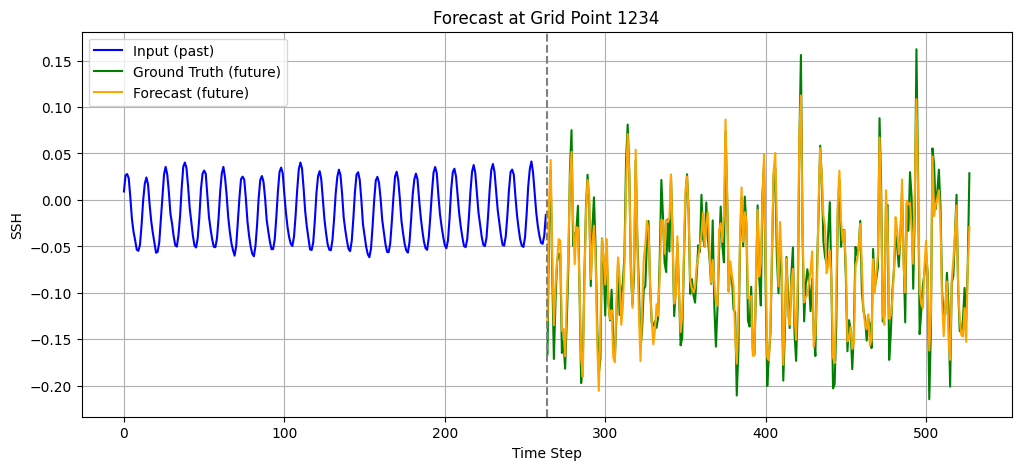

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(range(len(input_seq)), input_seq, label="Input (past)", color='blue')
plt.plot(range(len(input_seq), len(input_seq) + len(target_seq)), target_seq, label="Ground Truth (future)", color='green')
plt.plot(range(len(input_seq), len(input_seq) + len(forecast)), forecast, label="Forecast (future)", color='orange')

plt.axvline(x=len(input_seq), color='gray', linestyle='--')
plt.xlabel("Time Step")
plt.ylabel("SSH")
plt.title(f"Forecast at Grid Point {grid_point}")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import numpy as np

rmse = np.sqrt(mean_squared_error(target_seq, forecast))
r2 = r2_score(target_seq, forecast)
corr, _ = pearsonr(target_seq, forecast)

print(f"RMSE: {rmse:.6f}")
print(f"R² Score: {r2:.6f}")
print(f"Pearson Correlation: {corr:.6f}")


RMSE: 0.020993
R² Score: 0.902629
Pearson Correlation: 0.952086


In [ ]:
import matplotlib.pyplot as plt
import torch

def forecast_and_plot_gridpoint(model, x_grid, y_grid, grid_index, device):
    model.eval()
    context_seq = x_grid[grid_index]  # shape: (context_len,)
    true_future = y_grid[grid_index]  # shape: (pred_len,)

    # Prepare model input
    input_tensor = torch.from_numpy(context_seq).float().unsqueeze(0).unsqueeze(0).to(device)
    # shape becomes (1, 1, context_len)

    with torch.no_grad():
        forecast = model(input_tensor).cpu().squeeze().numpy()  # shape: (pred_len,)

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(range(len(context_seq)), context_seq, label='Input (past)', color='blue')
    plt.plot(range(len(context_seq), len(context_seq)+len(true_future)), true_future, label='Ground Truth (future)', color='green')
    plt.plot(range(len(context_seq), len(context_seq)+len(forecast)), forecast, label='Forecast (future)', color='orange')
    plt.axvline(x=len(context_seq)-1, color='gray', linestyle='--')
    plt.title(f"Forecast at Grid Point {grid_index}")
    plt.xlabel("Time Step")
    plt.ylabel("SSH")
    plt.legend()
    plt.tight_layout()
    plt.show()


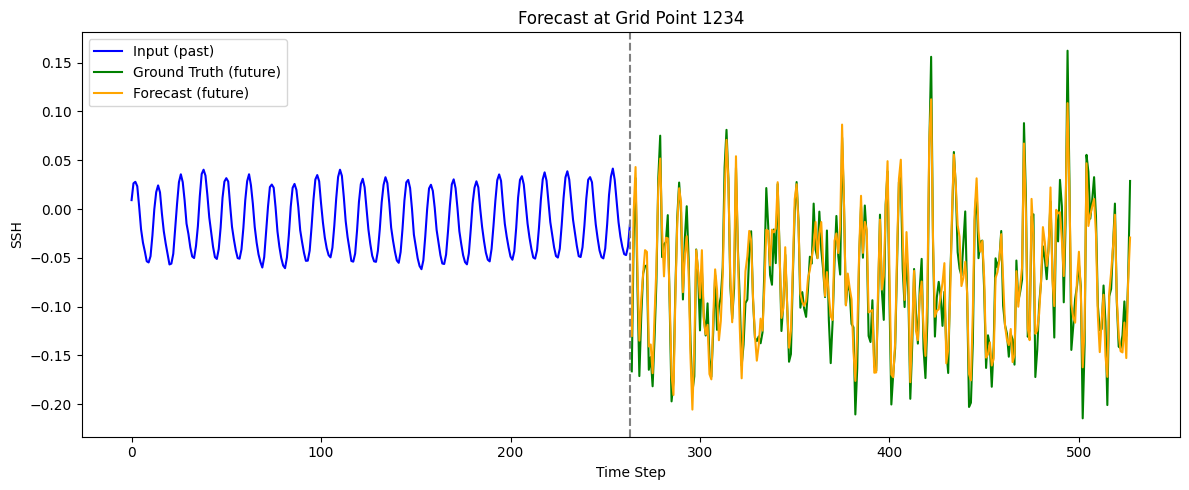

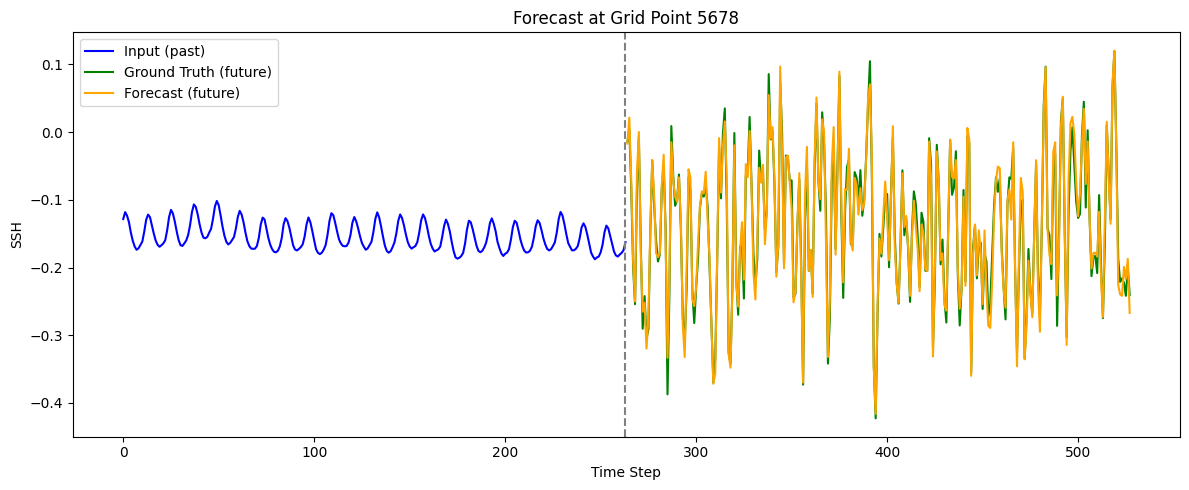

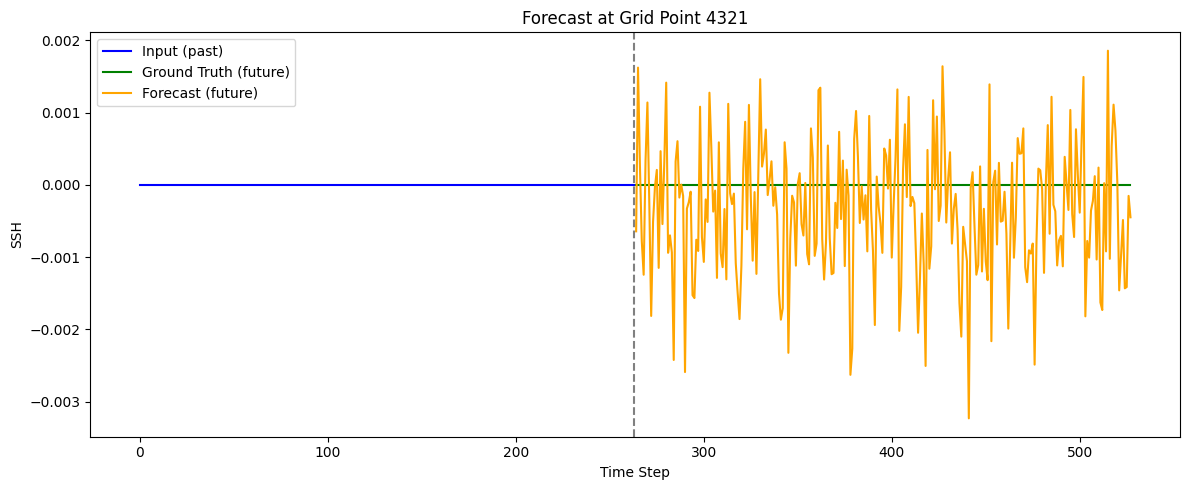

In [ ]:
# Choose any number of grid points to visualize
grid_points_to_plot = [1234, 5678, 4321]  # Replace with indices you care about

for idx in grid_points_to_plot:
    forecast_and_plot_gridpoint(model, X_grid, y_grid, idx, device)
